#Setup

In [1]:
import numpy as np
import pandas as pd
import json
import datetime
import tweepy
import time
import seaborn as sns
import os
import requests as req
import matplotlib.pyplot as plt

In [2]:
file_name = "../../ClassExamples/api_keys.json"
data = json.load(open(file_name))

consumer_key = data['twitter_consumer_key']
consumer_secret = data['twitter_consumer_secret']
access_token = data['twitter_access_token']
access_token_secret = data['twitter_access_token_secret']

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

#Load in datafiles

In [4]:
data_file = os.path.join("Revised National Names Male.csv")
national_names_male_df = pd.read_csv(data_file)
data_file = os.path.join("Revised National Names Female.csv")
national_names_female_df = pd.read_csv(data_file)
data_file = os.path.join("Revised State Names Male.csv")
state_names_male_df = pd.read_csv(data_file)
data_file = os.path.join("Revised State Names Female.csv")
state_names_female_df = pd.read_csv(data_file)

#Clean the datafiles

In [5]:
national_names_male_df.drop('Unnamed: 0', axis=1, inplace=True)
national_names_female_df.drop('Unnamed: 0', axis=1, inplace=True)
state_names_male_df.drop('Unnamed: 0', axis=1, inplace=True)
state_names_female_df.drop('Unnamed: 0', axis=1, inplace=True)

#Define the functions for plotting Male or Female results

In [6]:
def NamePlotMale (names,title):
    sns.set(rc={'figure.figsize':(11,8.5)})

    sns.axes_style()

    plt.title("Male Baby Name Frequency over Time",fontsize = 20)
    plt.xlabel("Year",fontsize = 20)
    plt.ylabel("Count of Name",fontsize = 20)

    labels=[]
    for name in names:
        plt.plot(national_names_male_df.loc[national_names_male_df["Name"]==name]["Year"],
                 national_names_male_df.loc[national_names_male_df["Name"]==name]["Count"])
        labels.append(name)

    plt.legend(labels, loc='upper right', bbox_to_anchor=[1.15,1], fontsize=14)
    plt.savefig (title +'.png')
    plt.show()

In [7]:
def NamePlotFemale (names,title):
    sns.set(rc={'figure.figsize':(11,8.5)})

    sns.axes_style()

    plt.title("Female Baby Name Frequency over Time",fontsize = 20)
    plt.xlabel("Year",fontsize = 20)
    plt.ylabel("Count of Name",fontsize = 20)

    labels=[]
    for name in names:
        plt.plot(national_names_female_df.loc[national_names_female_df["Name"]==name]["Year"],
                 national_names_female_df.loc[national_names_female_df["Name"]==name]["Count"])
        labels.append(name)

    plt.legend(labels, loc='upper right', bbox_to_anchor=[1.15,1], fontsize=14)
    plt.savefig (title +'.png')
    plt.show()

In [8]:
target_term = "@RocChalkChicken"

#Process the tweet from the bot account, pull the hashtag, make sure it's new, parse out the fields, then pull the relevant information from the datafiles, put together the tweet text, call the plotting function, then send the tweet back to the requestor with the picture attached

In [38]:
def NameTweet(lasttag):
    print('Start-----')
    
    public_tweets = api.search(target_term, count=1, result_type="recent")
    # Loop through all tweets
    for tweet in public_tweets["statuses"]:
        for hashtag in tweet["entities"]["hashtags"]:
            print(hashtag["text"])
            if hashtag["text"]==lasttag:
                print("we've already processed this hashtag "+lasttag)
                return(lasttag)
            lasttag=hashtag["text"]
            
        name,sex,state,year=hashtag["text"].split("_")
        tweetId = tweet['user']['screen_name']
        print(tweetId)

        if sex=="Male":
            national_count=national_names_male_df.loc[(national_names_male_df["Name"]==name)&
                                                     (national_names_male_df["Year"]==int(year))]["Count"]
            national_rank=national_names_male_df.loc[(national_names_male_df["Name"]==name)&
                                                     (national_names_male_df["Year"]==int(year))]["Rank"]
            total_count=national_names_male_df.loc[(national_names_male_df["Name"]==name)&
                                                     (national_names_male_df["Year"]==int(year))]["Total Count"]
            state_count=state_names_male_df.loc[(state_names_male_df["Name"]==name)&
                                               (state_names_male_df["State"]==state)&
                                               (state_names_male_df["Year"]==int(year))]["Count"]
            state_rank=state_names_male_df.loc[(state_names_male_df["Name"]==name)&
                                               (state_names_male_df["State"]==state)&
                                               (state_names_male_df["Year"]==int(year))]["Rank"]
            NamePlotMale([name],name)
            
        if sex=="Female":
            national_count=national_names_female_df.loc[(national_names_female_df["Name"]==name)&
                                                     (national_names_female_df["Year"]==int(year))]["Count"]
            national_rank=national_names_female_df.loc[(national_names_female_df["Name"]==name)&
                                                     (national_names_female_df["Year"]==int(year))]["Rank"]
            total_count=national_names_female_df.loc[(national_names_female_df["Name"]==name)&
                                                     (national_names_female_df["Year"]==int(year))]["Total Count"]
            state_count=state_names_female_df.loc[(state_names_female_df["Name"]==name)&
                                               (state_names_female_df["State"]==state)&
                                               (state_names_female_df["Year"]==int(year))]["Count"]
            state_rank=state_names_female_df.loc[(state_names_female_df["Name"]==name)&
                                               (state_names_female_df["State"]==state)&
                                               (state_names_female_df["Year"]==int(year))]["Rank"]
            NamePlotFemale([name],name)

        tweet =("@"+tweetId+" The name "+name+" was chosen "+ str(state_count.iloc[0])+" times in your state ("+state+
               ") in "+year+" and "+str(national_count.iloc[0])+" times nationally. It was ranked "+str(state_rank.iloc[0])+
               " in the state, and "+str(national_rank.iloc[0])+" nationally.  It has been used "+str(total_count.iloc[0])+
                " times in the US.")
        print(tweet)
    
        try:
            filename=name+'.png'

            api.update_with_media(filename, status=tweet)
            print("successfully tweeted")
        except tweepy.TweepError:
            print("unsuccessful")
    
    print('End-----')
    return(lasttag)

    


#Run the bot to scrap the twitter feed and call the function

Start-----
Betty_Female_KS_1933
TestiBotAccount


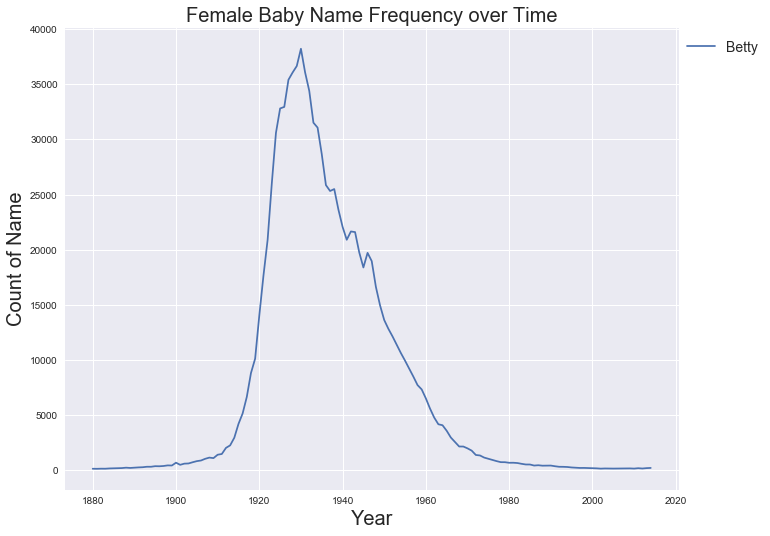

@TestiBotAccount The name Betty was chosen 511 times in your state (KS) in 1933 and 31526 times nationally. It was ranked 2 in the state, and 2 nationally.  It has been used 998851 times in the US.
successfully tweeted
End-----
Start-----
Betty_Female_KS_1933
we've already processed this hashtag Betty_Female_KS_1933
Start-----
Betty_Female_KS_1933
we've already processed this hashtag Betty_Female_KS_1933
Start-----
Betty_Female_KS_1933
we've already processed this hashtag Betty_Female_KS_1933
Start-----
Betty_Female_KS_1933
we've already processed this hashtag Betty_Female_KS_1933
Start-----
Betty_Female_KS_1933
we've already processed this hashtag Betty_Female_KS_1933
Start-----
Betty_Female_KS_1933
we've already processed this hashtag Betty_Female_KS_1933
Start-----
Jenna_Female_KS_2004
TestiBotAccount


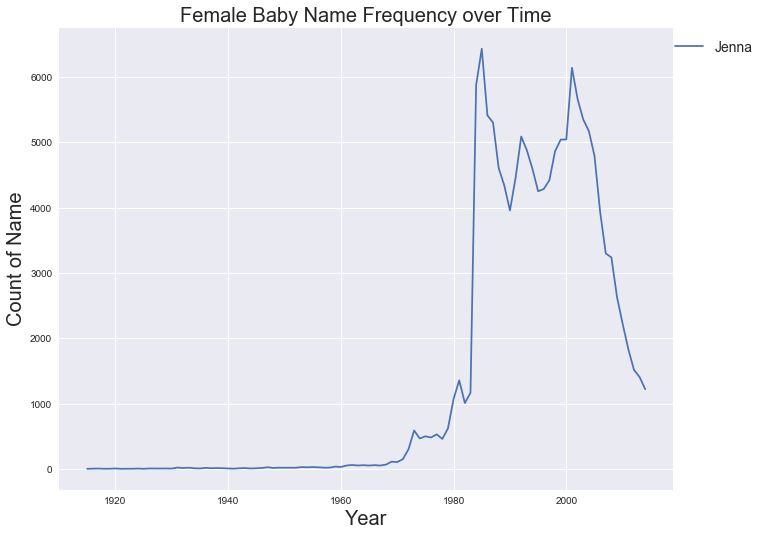

@TestiBotAccount The name Jenna was chosen 72 times in your state (KS) in 2004 and 5174 times nationally. It was ranked 33 in the state, and 56 nationally.  It has been used 141435 times in the US.
successfully tweeted
End-----
Start-----
Jenna_Female_KS_2004
we've already processed this hashtag Jenna_Female_KS_2004
Start-----
Jenna_Female_KS_2004
we've already processed this hashtag Jenna_Female_KS_2004
Start-----
Jenna_Female_KS_2004
we've already processed this hashtag Jenna_Female_KS_2004
Start-----
Jenna_Female_KS_2004
we've already processed this hashtag Jenna_Female_KS_2004
Start-----
Jenna_Female_KS_2004
we've already processed this hashtag Jenna_Female_KS_2004
Start-----
Jenna_Female_KS_2004
we've already processed this hashtag Jenna_Female_KS_2004
Start-----
Joshua_Male_KS_2004
TestiBotAccount


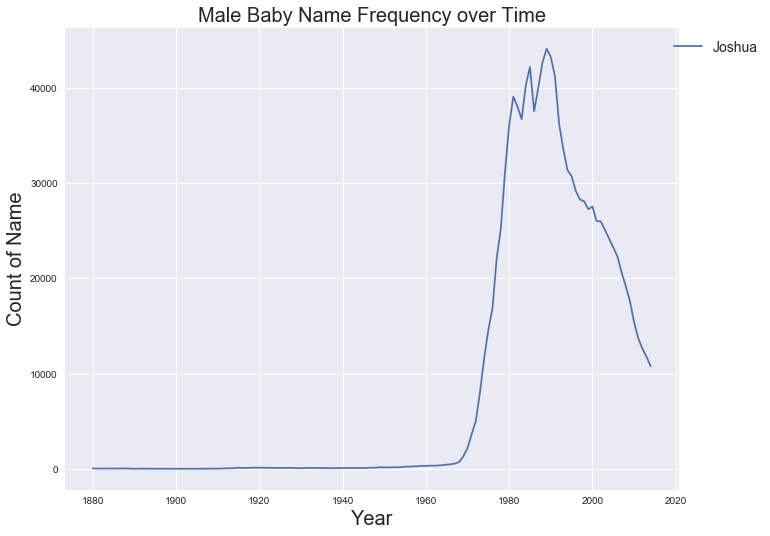

@TestiBotAccount The name Joshua was chosen 182 times in your state (KS) in 2004 and 24183 times nationally. It was ranked 7 in the state, and 3 nationally.  It has been used 1174787 times in the US.
successfully tweeted
End-----
Start-----
Joshua_Male_KS_2004
we've already processed this hashtag Joshua_Male_KS_2004
Start-----
Joshua_Male_KS_2004
we've already processed this hashtag Joshua_Male_KS_2004
Start-----
Joshua_Male_KS_2004
we've already processed this hashtag Joshua_Male_KS_2004
Start-----
Joshua_Male_KS_2004
we've already processed this hashtag Joshua_Male_KS_2004
Start-----
Joshua_Male_KS_2004
we've already processed this hashtag Joshua_Male_KS_2004


In [43]:
counter = 0
lasttag=" "

while True:
    
    try:
#    print("last tag before calling is " +lasttag)
        lasttag=NameTweet(lasttag)
    except:
        print("error with NameTweet")
 
    time.sleep(2)
    counter += 1
    if counter == 20:
        break